Copyright Preferred Computational Chemistry, Inc as contributors to Matlantis contrib project

# Structure search using CrySPY's ASE interface and PFP

本ノートブックでは、結晶構造探索ツールCrySPYに実装されているASEインターフェースとPFPを組み合わせることで、２元系化合物の結晶構造探索(Crystal Structure Search, CSP)を実行します。

### 事前セットアップ

pfp-api-client, matlantis-features, cryspyをインストールします。

執筆時点のCrySPY最新版は[v1.2.0](https://github.com/Tomoki-YAMASHITA/CrySPY/releases/tag/v1.2.0)です。

In [1]:
! pip install -U pfp-api-client
! pip install -U matlantis-features
! pip install -U csp-cryspy

### 1. パッケージのインポート

In [2]:
import os
import subprocess
import time
import pandas as pd
import matplotlib.pyplot as plt

from ase.io import read
from ase.spacegroup.symmetrize import FixSymmetry
from ase.geometry.analysis import Analysis

from pymatgen.io.cif import CifWriter
from pymatgen.io.ase import AseAtomsAdaptor

from matlantis_features.features.common.opt import LBFGSASEOptFeature
from matlantis_features.utils.calculators import pfp_estimator_fn

from pfp_api_client.pfp.estimator import EstimatorCalcMode

from utils import check_log_for_string 

os.makedirs("./output/calc_in", exist_ok = True)

### 2. 入力ファイルの作成

ASEインターフェースを用いてCrySPYを操作するために、`cryspy.in`, `calc_in/ase_in.py_1`, `calc_in/job_cryspy`の３種類のファイルを用意します。詳細は[公式ドキュメント](https://tomoki-yamashita.github.io/CrySPY_doc/ja/tutorial/random/ase/index.html)を参照してください。

#### cryspy.in

`cryspy.in`はCrySPYの計算条件を指定する入力ファイルです。以下に設定例を示します。本ノートブックでは8個の原子を含む二元系化合物CaSiのCSPを実行します。現実的な構造を生成するため、原子間距離の最小値を設定します。

- `atype = Ca Si` # 原子1と原子2の指定
- `mindist_1 = 2.5 2.0` # 原子1と原子1, 原子1と原子2の最小距離
- `mindist_2 = 2.0 2.0` # 原子2と原子1, 原子2と原子2の最小距離

進化的アルゴリズムに関連した設定は[EA]ブロックで定義します。構造の発生方法に関しては、[論文](https://www.tandfonline.com/doi/full/10.1080/27660400.2021.1943171)を参照してください。

以下のセルを実行すると、`cryspy.in`が作成されます。

In [3]:
%%writefile ./output/cryspy.in
[basic]
algo = EA
calc_code = ASE
tot_struc = 50
nstage = 1
njob = 10
jobcmd = bash
jobfile = job_cryspy

[structure]
natot = 8
atype = Ca Si
nat =  4 4
mindist_1 = 2.5 2.0
mindist_2 = 2.0 2.0

[ASE]
ase_python = ase_in.py

[EA]
n_pop = 30
n_crsov = 10
n_perm = 10
n_strain = 5
n_rand = 5
n_elite = 10
n_fittest = 15
fit_reverse = False
slct_func = TNM
t_size = 5
sigma_st = 0.10
crs_lat = equal
nat_diff_tole = 2
ntimes = 1
maxcnt_ea = 50
maxgen_ea = 5

[option]

Overwriting ./output/cryspy.in


#### calc_in/ase_in.py_1

CrySPYが生成した構造を、PFPを用いて緩和するためのプログラムが実装されています。ここではPFPの計算モードを`CRYSTAL_U0`としています。必要に応じて修正してください。3つの格子ベクトルが同一平面に接近した特殊な構造が生成されることがあります。ここでは、格子ベクトルの角度が一定の閾値を下回る構造のエネルギーをゼロとしてフィルタリングしています。

In [4]:
%%writefile ./output/calc_in/ase_in.py_1
import os
import numpy as np

from ase.spacegroup.symmetrize import FixSymmetry
from ase.io import read, write

from pfp_api_client.pfp.calculators.ase_calculator import ASECalculator
from pfp_api_client.pfp.estimator import EstimatorCalcMode

from matlantis_features.features.common.opt import LBFGSASEOptFeature
from matlantis_features.utils.calculators import pfp_estimator_fn

# ---------- input structure
# CrySPY outputs 'POSCAR' as an input file in work/xxxxxx directory
atoms = read('POSCAR', format='vasp')

# ---------- setting and run    
def filter_structure(atoms_cell):
    n = np.cross(atoms_cell[0], atoms_cell[1])
    c = atoms_cell[2]
    # Calculate the dot product between c and n
    dot_product = np.dot(c, n)

    # Calculate the magnitudes of c and n
    mag_c = np.linalg.norm(c)
    mag_n = np.linalg.norm(n)

    # Calculate the cosine of the angle theta
    cos_theta = dot_product / (mag_c * mag_n)

    # Calculate the angle theta in radians
    theta_rad = np.arccos(np.clip(cos_theta, -1, 1))

    # Convert theta from radians to degrees if needed
    theta_deg = np.degrees(theta_rad)

    # print("Theta (in degrees):", np.abs(90 - theta_deg))

    if np.abs(90 - theta_deg) > 75.0:
        return True
    else:
        return False

if filter_structure(atoms.cell):
    atoms.set_constraint([FixSymmetry(atoms)])
    opt = LBFGSASEOptFeature(n_run=1000,
                             filter=True,
                             estimator_fn=pfp_estimator_fn(
                                 model_version="v5.0.0",
                                 calc_mode=EstimatorCalcMode.CRYSTAL_U0,
                             ),
                            )
    result_opt = opt(atoms)
    e = result_opt.atoms.ase_atoms.get_total_energy()
    with open('log.tote', mode='w') as f:
        f.write(str(e))

    write('CONTCAR', result_opt.atoms.ase_atoms, format='vasp')

else:
    with open('log.tote', mode='w') as f:
        f.write(str(1e10))

    write('CONTCAR', atoms, format='vasp')

Overwriting ./output/calc_in/ase_in.py_1


#### calc_in/job_cryspy

ASEインターフェースを実行するためのスクリプトです。

In [5]:
%%writefile ./output/calc_in/job_cryspy
#!/bin/sh

# ---------- ASE
python ase_in.py

# ---------- CrySPY
sed -i -e '3 s/^.*$/done/' stat_job

Overwriting ./output/calc_in/job_cryspy


### 3. CrySPYの実行

CrySPYの実行コマンドcryspyを、入力ファイルが存在するディレクトリで最大世代数(`maxgen_ea`)に到達するまで実行します。ここでは20秒毎にsubprocessモジュールを用いてノートブック上からcryspyコマンドを実行します。ログファイル（`log_cryspy`）を参照し、最終世代に到達した段階でループを抜けます。

計算結果の画面出力は破棄しています。ログを確認したい場合`log_cryspy`や`err_cryspy`を参照してください。

10並列(`njob = 10`)で実行した場合、30分程度で計算が完了します。

In [6]:
while True:
    try:
        # cryspyの実行
        subprocess.run(['cryspy'], cwd= "./output",
                       stdout=subprocess.DEVNULL, stderr=subprocess.DEVNULL, check=True)

        # logファイルに"Reached maxgen_ea"が表示された場合計算を終了
        if check_log_for_string("./output/log_cryspy", "Reached maxgen_ea"):
            print(f"Reached maxgen_ea found in log_cryspy. Exiting...")
            break

        # 20秒ごとにcryspyを実行
        time.sleep(20)

    except Exception as e:
        print(f"An error occurred: {e}")
        break

### 4. 計算結果の可視化

各世代各構造に対するエネルギーは`data/cryspy_rslt`に保存されています。世代ごとの構造のエネルギーを比較しましょう。ランダム生成した第一世代に対し、世代を増やすことで最安定構造が更新されています。

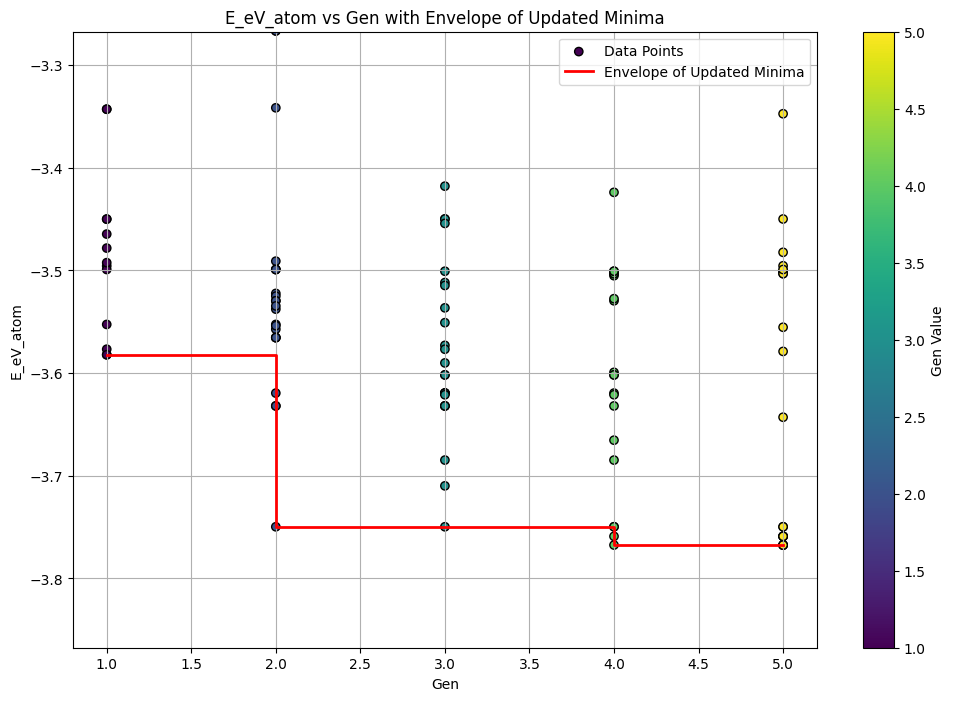

In [7]:
file_path = "./output/data/cryspy_rslt"
# DataFrame形式で結果を読み込み
df = pd.read_csv(file_path, delim_whitespace=True)

# パラメータの初期化
current_min = float('inf')
current_gen = 0

envelope_gen = []
envelope_eV = []

# 包絡線をプロットするためのポイントの探索
min_values_by_gen = df.groupby('Gen')['E_eV_atom'].min().reset_index().sort_values('Gen')
for _, row in min_values_by_gen.iterrows():
    if row['E_eV_atom'] < current_min:
        current_min = row['E_eV_atom']
        envelope_gen.append(row['Gen'])
        envelope_eV.append(current_min)
    else:
        envelope_gen.append(row['Gen'])
        envelope_eV.append(current_min)

# 描画
plt.figure(figsize=(12, 8))
scatter = plt.scatter(df['Gen'], df['E_eV_atom'], c=df['Gen'], cmap='viridis', edgecolors='k', label='Data Points')
plt.colorbar(scatter, label='Gen Value')
plt.step(envelope_gen, envelope_eV, color='r', where='post', linewidth=2, label='Envelope of Updated Minima')

os.makedirs("./output/fig", exist_ok = True)
plt.xlabel('Gen')
plt.ylabel('E_eV_atom')
plt.ylim(min(df['E_eV_atom']) - 0.1, min(df['E_eV_atom']) + 0.5)
plt.title('E_eV_atom vs Gen with Envelope of Updated Minima')
plt.legend()
plt.grid(True)
plt.savefig("./output/fig/E_eV_atom_vs_Gen_with_Envelope.png")
plt.show()

### 5.安定構造の確認

安定構造が実験構造（空間群：Cmcm）と一致するか検証します。最も安定な複数の上位構造がCmcmの空間群を有することを確認できます。

In [8]:
df_sorted = df.sort_values(by='E_eV_atom')
df_sorted.head(10)

,Gen,Spg_num,Spg_sym,Spg_num_opt,Spg_sym_opt,E_eV_atom,Magmom,Opt
141,5,1,P1,63,Cmcm,-3.767506,NaN,no_file
160,5,2,P-1,63,Cmcm,-3.767505,NaN,no_file
149,5,2,P-1,63,Cmcm,-3.767503,NaN,no_file
115,4,1,P1,63,Cmcm,-3.767501,NaN,no_file
161,5,2,P-1,63,Cmcm,-3.767500,NaN,no_file
164,5,2,P-1,62,Pnma,-3.758998,NaN,no_file
113,4,1,P1,62,Pnma,-3.758996,NaN,no_file
143,5,2,P-1,62,Pnma,-3.758995,NaN,no_file
145,5,11,P2_1/m,62,Pnma,-3.758995,NaN,no_file
162,5,2,P-1,62,Pnma,-3.758993,NaN,no_file


RDF(動径分布関数)を計算し、構造を比較します。Materials Projectに登録されている構造と今回生成された構造のRDFが良く一致することを確認できます(注：Matlantis-Contribには上位3個の安定構造の関連ファイルのみを保存しています)。最後に、安定構造をcif形式で保存しています。

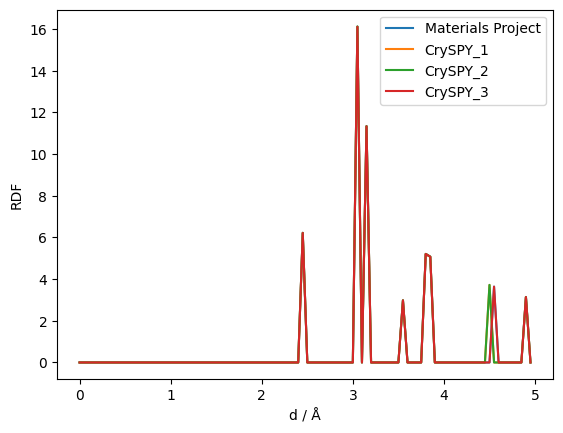

In [9]:
# Materials Project登録データをAtomsオブジェクトとして取得
atoms = read("./input/cif/CaSi.cif")
atoms.set_constraint([FixSymmetry(atoms)])
opt = LBFGSASEOptFeature(filter=True,
                         estimator_fn = pfp_estimator_fn(
                             model_version="v5.0.0",
                             calc_mode=EstimatorCalcMode.CRYSTAL_U0,
                         ),
                        )
result_opt = opt(atoms)
result_opt.atoms.ase_atoms.set_constraint()

# 上位3構造を取得
stable_index = df_sorted.index[:3]
atoms_list = [result_opt.atoms.ase_atoms]
for idx in stable_index:
    file_path = f"./output/work/fin/{str(idx).zfill(6)}/CONTCAR"
    atoms_list.append(read(file_path))

# RDFのプロット
rmax = 5
nbins = 100
delta = [(rmax/nbins)*i for i in range(nbins)]
for n, atoms in enumerate(atoms_list):
    atoms *= (5,5,5)
    ana = Analysis(atoms)
    rdf = ana.get_rdf(rmax,nbins,elements=["Ca","Si"])[0]
    if n == 0:
        plt.plot(delta, rdf, label="Materials Project")
    else:
        plt.plot(delta, rdf, label=f"CrySPY_{n}")

plt.xlabel("d / Å")
plt.ylabel("RDF")
plt.legend()
plt.show()

# cif形式で保存
os.makedirs("./output/cif", exist_ok = True)
for n, atoms in enumerate(atoms_list):
    if n == 0:
        continue
    else:
        strct = AseAtomsAdaptor.get_structure(atoms)
        cw = CifWriter(strct, symprec=0.01)
        cw.write_file(f"./output/cif/CrySPY_{n}.cif")

### 6. 結論と次のステップ

CSPソフトウェアで生成された構造の緩和にPFPを用いることで、DFTを用いた場合に比べ圧倒的に高速な計算が可能となり、今回のケースのように正解構造を得られる場合があります。更に、様々な組成のCSPを実行することで多元素系の凸包（convex hull）を作成できます。プログラム作成例は[こちらのnotebook](https://github.com/matlantis-pfcc/matlantis-contrib/blob/main/matlantis_contrib_examples/cryspy_example_ase/cryspy_advanced_ja.ipynb)をご確認ください。